# Assignment 1 - Image Fundamentals

Class: COMP 5970 - Computer Vision

Author: Chris Hinkson

Email: cmh0201@auburn.edu

*Personal Contribution Statement: This was an individual project and I did everything in it.*

*Generative AI Declaration: ChatGPT was used to explain package syntax and to see examples of how to use package syntax (specifically: cv2, ipywidget, and matplotlib syntax). All code provided here is written by myself with some inspiration from Dr. Aakur's class examples and the examples generated by ChatGPT.*

## Task 1 Report: Photometric Decoder

The goal of Task 1 is to build a Photometric Decoder that reveals a hidden phrase or message in a provided photograph. For full details, see [Assignment1.pdf](../Assignment1.pdf).

### Approach Strategy

My approach strategy for Task 1 was to first build a set of tools that would allow me to easily modify values. I could then use these tools to complete photometric operations to find the optimal configuration for revealing the code. 

I started off by just adjusting each setting on its own (brightness, contrast, gamma, greyscale) to see if there were any obvious limits; from this, I found that each setting for brightness, contrast, and gamma would need a lot of balance. By setting a modifier to a high value (for brightness, > 1, for contrast, > 5, for gamma, > 3), the image would quickly not even be recognizable as having any content. I tested combinations of each, slowly adjusting it to be slightly more revealing and then moving on to the next photometric modifier.

I eventually found that brightness values close to 0.5, contrast values around 2-3, and gamma values < 1 performed the best. I continued to make smaller and smaller adjustments until I found the optimal configuration, described in the Results section of this report.

### Implementation

The first step of my implementation was to create all of the tools necessary for modifying the image. I initially made an ImageModifier class that handles the brightness, contrast, gamma, and greyscale modifications to an image, all of which are based on Dr. Aakur's examples from class. I then created an ImageDisplay class to easily display and save images using matplotlib. 

To easily test different image configurations, I used ipywidgets, which are designed for Jupyter notebooks. These allow for things like sliders (which I used for changing brightness, contrast, gamma, and greyscale setting) and buttons (which I used to save configurations found in the interactive display). 

Overall, the implementation shown here is relatively simple: create classes to handle image modifications and displays -> use ipywidgets to interactively control these modifications -> identify the best results.

### Dependencies and Runtime Instructions

For Task 1, there are several dependencies required for the program:
1) Python's [Enums](https://docs.python.org/3/library/enum.html) and [Warnings](https://docs.python.org/3/library/warnings.html) for system support
2) [Numpy](https://numpy.org/) for storing images
3) [CV2](https://opencv.org/) for loading and saving images
4) [IPython Display Module](https://ipython.readthedocs.io/en/9.0.0/api/generated/IPython.display.html), [ipywidget](https://ipywidgets.readthedocs.io/en/stable/), and [matplotlib](https://matplotlib.org/) for interactive output

Before running the program, ensure that an `images` directory is located at the same file level as this program (in Colab, just place the directory at the top-level of the file browser). Inside the images directory, place the `photometric_hidden_image.png`.

To run the program, you simply need to run the below three cells. The first cell will create all of the needed classes, and the second will initialize some instances of them and provide an interactive image output with sliders for controlling the image modification parameters and saving any modified images. Note that the save button will save images to the [images](images/) directory. The third and final cell for Task 1 recreates the image configuration that I found best-reveals the secret phrase.

### Task 1 Results

With the interactive image output provided in the second code cell below, I was able to adjust values and find a configuration that best reveals the secret code phrase "CV is cool" (and spongebob). I created the third code cell to always display this configuration.

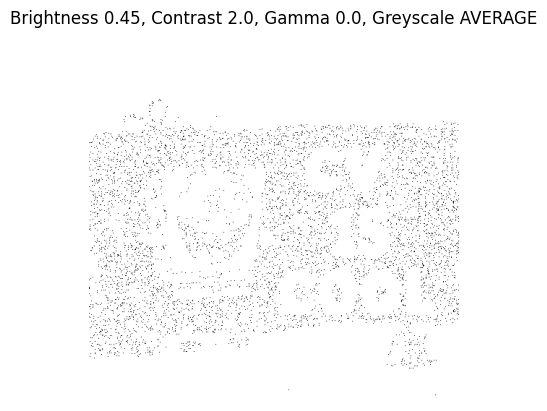

While other values for the brightness, contrast, gamma, and greyscale setting can also somewhat reveal the phrase, these settings provided the clearest identification of the phrase possible.


In [ ]:
'''
MODULE IMPORTS
'''

# System
from enum import Enum
from warnings import warn

# Data
import numpy as np

# Image Processing
import cv2

# Display
from IPython.display import display, clear_output
from ipywidgets import interact, FloatSlider, SelectionSlider, Button
import matplotlib.pyplot as plt

'''
ENUM CREATION

Enums are used to help with code readability and usability:
- GreyscaleType: Enum for the different types of grayscale conversions
'''
class GreyscaleType(Enum):
	COLOR = 0
	AVERAGE = 1
	WEIGHTED = 2

'''
IMAGE DISPLAY CLASS

The first class contains methods for displaying images in the Jupyter environment
via IPython display. It also allows for a title to be displayed above the image.
'''
class ImageDisplay:

	# Class Constructor
	def __init__(self):

		# Initialize instance variables
		self.image = None
		self.title = "Image"
		self.im = None

		# Setup matplotlib
		self.fig, self.ax = plt.subplots()
		plt.close(self.fig)

	# Show Image
	def showImage(self, image, title: str="Image", doGreyMap: bool=False):

		# Save image
		self.image = image
		self.title = title

		# Display the image, mapped in greyscale if specified
		if self.im is None:
			self.ax.axis("off")
			self.im = self.ax.imshow(image, cmap=("gray" if doGreyMap else None))
		else:
			self.im.set_data(image)
			self.im.set_cmap(cmap=("gray" if doGreyMap else None))

		# Set title
		self.ax.set_title(title)

		# Draw new image then clear and display output
		self.fig.canvas.draw_idle()
		clear_output(wait=True)
		display(self.fig)

	# Save Image
	def saveImage(self, filename: str=None):

		# Ensure an image has been displayed
		if self.image is None:
			raise ValueError("No image has been displayed yet!")
		
		# If no filename provided, use title
		if filename is None or filename == "":
			filename = f"images/{self.title.replace(' ', '_')}.png"

		# Save the image to a file
		self.fig.savefig(filename)

'''
IMAGE MODIFICATION CLASS

This class will provide methods for modifying images inline with the assignment
description. Note that this uses cv2's MatLike type for images, since cv2 will be
used for image loading and saving.
'''
class ImageModifier:

	# Class Constructor
	def __init__(self, image: cv2.typing.MatLike):

		# Initialize instance variables
		self.image = image

	# Get Image Method
	def getImage(self, greyscaleType: GreyscaleType=GreyscaleType.COLOR) -> cv2.typing.MatLike:
		
		# Ensure image has been set
		if self.image is None:
			raise ValueError("No image has been loaded yet!")

		# Return the image in the specified greyscale type
		if greyscaleType == GreyscaleType.AVERAGE:
			return self.changeImageGreyscale(self.image, GreyscaleType.AVERAGE)
		elif greyscaleType == GreyscaleType.WEIGHTED:
			return self.changeImageGreyscale(self.image, GreyscaleType.WEIGHTED)
		else:
			return self.image

	# Change Image Brightness (Inspired by Dr. Aaukur's class example)
	def changeImageBrightness(self, image: cv2.typing.MatLike=None, brightnessModifier: int=0, returnGreyscaleType: GreyscaleType=GreyscaleType.COLOR) -> cv2.typing.MatLike:

		# Ensure image has been set, and if not, use the instance image
		if image is None:
			image = self.image

		# Adjust brightness for all pixels in img
		image = (image.astype(np.float32)/255.) + brightnessModifier

		# Perform intensity clipping for [0,1]
		image = np.where(image > 1, 1, image)
		image = np.where(image < 0, 0, image)

		# Set the image back to [0,255]
		image = (image * 255).astype(np.uint8)

		# Return the modified image, in the specified greyscale type
		if returnGreyscaleType == GreyscaleType.AVERAGE:
			return self.changeImageGreyscale(image, GreyscaleType.AVERAGE)
		elif returnGreyscaleType == GreyscaleType.WEIGHTED:
			return self.changeImageGreyscale(image, GreyscaleType.WEIGHTED)
		else:
			return image

	# Make Image Greyscale (Inspired by Dr. Aaukur's class example)
	def changeImageGreyscale(self, image: cv2.typing.MatLike=None, greyscaleType: GreyscaleType=GreyscaleType.WEIGHTED) -> cv2.typing.MatLike:

		# Ensure image has been set, and if not, use the instance image
		if image is None:
			image = self.image

		# Build average-greyscale image
		if greyscaleType == GreyscaleType.AVERAGE:
			greyscaleImage = (image[:,:,0].astype(float) + image[:,:,1].astype(float) + image[:,:,2].astype(float))/3
			greyscaleImage = greyscaleImage.astype (np.uint8)
			return greyscaleImage

		# Build weighted-greyscale image
		elif greyscaleType == GreyscaleType.WEIGHTED:
			greyscaleImage = (0.2125 * image[:,:,0].astype(float) + 0.7154 * image[:,:,1].astype(float) + 0.721 * image[:,:,2].astype(float))/3
			greyscaleImage = greyscaleImage.astype (np.uint8)
			return greyscaleImage
		
		# If color, return original image
		else:
			return image

	# Change Image Contrast (Inspired by Dr. Aaukur's class example)
	def changeImageContrast(self, image: cv2.typing.MatLike=None, contrastModifier: float=1.0, returnGreyscaleType: GreyscaleType=GreyscaleType.COLOR) -> cv2.typing.MatLike:

		# Ensure image has been set, and if not, use the instance image
		if image is None:
			image = self.image

		# Adjust contrast for all pixels in image (can either be single modifier for all or a matrix)
		image = image.astype(np.float32)/255.
		image = contrastModifier * image

		# Perform intensity clipping for [0,1]
		image = np.where(image > 1, 1, image)
		image = np.where(image < 0, 0, image)

		# Set the image back to [0,255]
		image = (image * 255).astype(np.uint8)

		# Return the modified image, in the specified greyscale type
		if returnGreyscaleType == GreyscaleType.AVERAGE:
			return self.changeImageGreyscale(image, GreyscaleType.AVERAGE)
		elif returnGreyscaleType == GreyscaleType.WEIGHTED:
			return self.changeImageGreyscale(image, GreyscaleType.WEIGHTED)
		else:
			return image
		
	# Change Image Gamma (Inspired by Dr. Aaukur's class example)
	def changeImageGamma(self, image: cv2.typing.MatLike=None, gammaModifier: float=1.0, returnGreyscaleType: GreyscaleType=GreyscaleType.COLOR) -> cv2.typing.MatLike:

		# Ensure image has been set, and if not, use the instance image
		if image is None:
			image = self.image

		# Incase of zero, use very small epsilon value and warn
		if gammaModifier == 0:
			warn("Gamma modifier cannot be zero, using 0.001 instead")
			gammaModifier = 0.001

		# Adjust gamma for all pixels in image
		image = image.astype(np.float32)/255.
		image = (np.power(image, 1/gammaModifier))

		# Perform intensity clipping for [0,1]
		image = np.where(image > 1, 1, image)
		image = np.where(image < 0, 0, image)

		# Set the image back to [0,255]
		image = (image * 255).astype(np.uint8)

		# Return the modified image, in the specified greyscale type
		if returnGreyscaleType == GreyscaleType.AVERAGE:
			return self.changeImageGreyscale(image, GreyscaleType.AVERAGE)
		elif returnGreyscaleType == GreyscaleType.WEIGHTED:
			return self.changeImageGreyscale(image, GreyscaleType.WEIGHTED)
		else:
			return image


In [93]:
'''
MAIN EXECUTION

This cell creates instances of the classes and presents an interactive display for modifying images.
'''

# Get the image and load it into a modifier class and make a display for it
photometricHiddenImage = cv2.imread("images/photometric_hidden_image.png")
photometricHiddenImage = cv2.cvtColor(photometricHiddenImage, cv2.COLOR_BGR2RGB)
photometricImageModifier = ImageModifier(photometricHiddenImage)
imageDisplayer = ImageDisplay()

# Provide interactive display for modifying brightness, contrast, gamma, and greyscale type
@interact(brightnessModifier=FloatSlider(min=-5.0,max=5.0,step=0.05,value=0.0), contrastModifier=FloatSlider(min=0.0,max=10.0,step=0.05,value=1.0), gammaModifier=FloatSlider(min=0.0,max=10.0,step=0.05,value=1.0), greyscaleType=SelectionSlider(options=[(t.name, t) for t in GreyscaleType], value=GreyscaleType.COLOR, continuous_update=False))
def modifyImageDisplay(brightnessModifier: float=0.0, contrastModifier: float=1.0, gammaModifier: float=1.0, greyscaleType: GreyscaleType=GreyscaleType.COLOR):
	modifiedImage = photometricImageModifier.changeImageBrightness(brightnessModifier=brightnessModifier)
	modifiedImage = photometricImageModifier.changeImageContrast(image=modifiedImage, contrastModifier=contrastModifier)
	modifiedImage = photometricImageModifier.changeImageGamma(image=modifiedImage, gammaModifier=gammaModifier)
	modifiedImage = photometricImageModifier.changeImageGreyscale(image=modifiedImage, greyscaleType=greyscaleType)
	if greyscaleType == GreyscaleType.COLOR:
		imageDisplayer.showImage(modifiedImage, f"Brightness {brightnessModifier}, Contrast {contrastModifier}, Gamma {gammaModifier}, Greyscale {greyscaleType.name}")
	else:
		imageDisplayer.showImage(modifiedImage, f"Brightness {brightnessModifier}, Contrast {contrastModifier}, Gamma {gammaModifier}, Greyscale {greyscaleType.name}", doGreyMap=True)

# Provide button for saving image
button = Button(description='Click to save image!', disabled=False, button_style='', tooltip='Click to save image!')
button.on_click(lambda buttonPress: imageDisplayer.saveImage())
button

interactive(children=(FloatSlider(value=0.0, description='brightnessModifier', max=5.0, min=-5.0, step=0.05), …

Button(description='Click to save image!', style=ButtonStyle(), tooltip='Click to save image!')

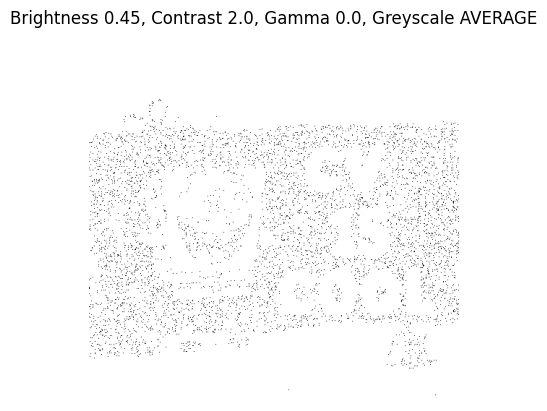

In [94]:
'''
TASK 1 RESULTS

This cell will provide the image configuration that I found best-revealed the secret phrase.
'''

# Load the provided image
photometricHiddenImage = cv2.imread("images/photometric_hidden_image.png")
photometricHiddenImage = cv2.cvtColor(photometricHiddenImage, cv2.COLOR_BGR2RGB)
photometricImageModifier = ImageModifier(photometricHiddenImage)

# Apply brightness, contrast, gamma, and greyscale modifications
modifiedImage = photometricImageModifier.changeImageBrightness(brightnessModifier=0.45)
modifiedImage = photometricImageModifier.changeImageContrast(image=modifiedImage, contrastModifier=2.0)
modifiedImage = photometricImageModifier.changeImageGamma(image=modifiedImage, gammaModifier=0.0)
modifiedImage = photometricImageModifier.changeImageGreyscale(image=modifiedImage, greyscaleType=GreyscaleType.AVERAGE)

# Display the results
finalImageDisplayer = ImageDisplay()
finalImageDisplayer.showImage(modifiedImage, "Brightness 0.45, Contrast 2.0, Gamma 0.0, Greyscale AVERAGE", doGreyMap=True)


## Task 2 Report: Geometric Puzzle Solver

The goal of Task 2 is to build a Geometric Puzzle Solver that performs transformations on tiles in a given image to unscramble the image. For full details, see [Assignment1.pdf](../Assignment1.pdf).

### Approach Strategy

My approach strategy for Task 2 was similar to that of Task 1. First was to create a set of tools that would allow for easily modifying the image. Knowing the possible transformations, this included flipping, rotating, and swapping. Once these were created, the image tiles could be tinkered with until the final image was produced. 

### Implementation

My implementation for Task 2 was also very similar to Task 1. I used the same ImageDisplay class for displaying the images with matplotlib. I then created an ImageTransformer class for handling all of the transformations to the image tiles. Additionally, I created a GeometricLogger class that would allow for the steps taken in the interactive transforming of the image to be recorded and replayed at a later time. Widgets were again used to provide an interactive control over transformations to unscramble the image.

### Dependencies and Runtime Instructions

For Task 2, there are several dependencies required for the program:
1) Python's [Enums](https://docs.python.org/3/library/enum.html) and [Warnings](https://docs.python.org/3/library/warnings.html) for system support
2) [CV2](https://opencv.org/) for loading and saving images
3) [IPython Display Module](https://ipython.readthedocs.io/en/9.0.0/api/generated/IPython.display.html), [ipywidget](https://ipywidgets.readthedocs.io/en/stable/), [matplotlib](https://matplotlib.org/), [tqdm](https://tqdm.github.io/) for interactive output

Before running the program, ensure that an `images` directory is located at the same file level as this program (in Colab, just place the directory at the top-level of the file browser). Inside the images directory, place the `geometric_puzzle_scrambled.png`.

To run the program, you simply need to run the below three cells. The first cell will create all of the needed classes, and the second will initialize some instances of them and provide an interactive image output with dropdowns for controlling image transformations and saving any modified images. Note that the save button will save images to the [images](images/) directory. 

The third and final cell for Task 2 replays all of the transformation steps taken in the interactive output. You can either use your own generated replay steps or use [the geolog.txt available on my github](https://github.com/cmh02/COMP5970---Computer-Vision/blob/e63d4eb089a3617fa476b72cef5cec97c13b0e60/Assignment%201%20-%20Image%20Fundamentals/src/logs/geolog.txt). If you are using my provided log file, just ensure that the log file is placed in a `logs` directory located at the same file level as this program.

### Task 2 Results

After a variety of flips, rotations, and swaps, the tiles were unscrambled, revealing the final image:

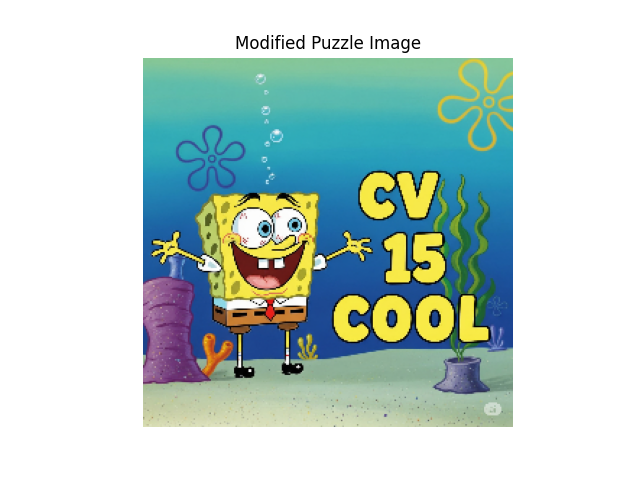

In [169]:

'''
MODULE IMPORTS
'''

# System
from enum import Enum
from time import sleep

# Image Processing
import cv2

# Display
from IPython.display import display, clear_output
from ipywidgets import interact, Dropdown
import matplotlib.pyplot as plt
from tqdm import tqdm

'''
ENUM CREATION

Enums are used to help with code readability and usability:
- FlipType: Enum for the different types of flips (I based this on cv2's flip function param)
- RotateType: Enum for the different types of rotations (I based this on cv2's rotate enums)
- SwapType: Enum for the different types of swaps (Only used in interactive widget)
'''

class FlipType(Enum):
	NONE = None
	BOTH = -1
	VERTICAL = 0
	HORIZONTAL = 1

class RotateType(Enum):
	NONE = None
	CLOCKWISE_90 = cv2.ROTATE_90_CLOCKWISE
	CLOCKWISE_180 = cv2.ROTATE_180
	CLOCKWISE_270 = cv2.ROTATE_90_COUNTERCLOCKWISE

class SwapType(Enum):
	NONE = None
	UP = "UP"
	DOWN = "DOWN"
	LEFT = "LEFT"
	RIGHT = "RIGHT"

'''
IMAGE DISPLAY CLASS

The first class contains methods for displaying images in the Jupyter environment
via IPython display. It also allows for a title to be displayed above the image.
'''
class ImageDisplay:

	# Class Constructor
	def __init__(self):

		# Initialize instance variables
		self.image = None
		self.title = "Image"
		self.im = None

		# Setup matplotlib
		self.fig, self.ax = plt.subplots()
		plt.close(self.fig)

	# Show Image
	def showImage(self, image, title: str="Image"):

		# Save image
		self.image = image
		self.title = title

		# Display the image, mapped in greyscale if specified
		if self.im is None:
			self.ax.axis("off")
			self.im = self.ax.imshow(image)
		else:
			self.im.set_data(image)

		# Set title
		self.ax.set_title(title)

		# Draw new image then clear and display output
		self.fig.canvas.draw_idle()
		clear_output(wait=True)
		display(self.fig)

	# Save Image
	def saveImage(self, filename: str=None):

		# Ensure an image has been displayed
		if self.image is None:
			raise ValueError("No image has been displayed yet!")
		
		# If no filename provided, use title
		if filename is None or filename == "":
			filename = f"images/{self.title.replace(' ', '_')}.png"

		# Save the image to a file
		self.fig.savefig(filename)

'''
IMAGE TRANSFORMER CLASS

This class will provide easy transformations for images (based on tiles)
'''
class ImageTransformer:

	# Class Constructor
	def __init__(self, image: cv2.typing.MatLike, tileSize: int=64):
		
		# Initialize instance variables
		self.image = image
		self.tileSize = tileSize

		# Calculate number of tiles in each dimension
		self.numberTiles = (self.image.shape[0]//self.tileSize, self.image.shape[1]//self.tileSize)

		# Print information about the image and tiles
		print(f"Image shape: {self.image.shape}, Tile size: {self.tileSize}, Number of tiles: {self.numberTiles}")

	# Get Image Method
	def getImage(self) -> cv2.typing.MatLike:

		# Ensure image has been set
		if self.image is None:
			raise ValueError("No image has been loaded yet!")
		
		return self.image
	
	# Get specific tile
	def getTile(self, tileRow: int, tileCol: int) -> cv2.typing.MatLike:

		# Ensure image has been set
		if self.image is None:
			raise ValueError("No image has been loaded yet!")
		
		# Ensure that the tile indices are valid
		if (tileRow < 0 or tileRow >= self.numberTiles[0] or tileCol < 0 or tileCol >= self.numberTiles[1]):
			raise ValueError(f"Tile indices ({tileRow}, {tileCol}) are out of bounds for number of tiles {self.numberTiles}!")

		# Calculate the beginning and ending pixel indices for specified tile
		rowStart = tileRow * self.tileSize
		rowEnd = rowStart + self.tileSize
		colStart = tileCol * self.tileSize
		colEnd = colStart + self.tileSize

		# Return the tile as just the pixels in the specified bounds
		return self.image[rowStart:rowEnd, colStart:colEnd].copy()

	# Set specific tile
	def setTile(self, tileRow: int, tileCol: int, newTile: cv2.typing.MatLike):

		# Ensure image has been set
		if self.image is None:
			raise ValueError("No image has been loaded yet!")
		
		# Ensure that the tile indices are valid
		if (tileRow < 0 or tileRow >= self.numberTiles[0] or tileCol < 0 or tileCol >= self.numberTiles[1]):
			raise ValueError(f"Tile indices ({tileRow}, {tileCol}) are out of bounds for number of tiles {self.numberTiles}!")

		# Ensure that the new tile is the correct size
		if (newTile.shape[0] != self.tileSize or newTile.shape[1] != self.tileSize):
			raise ValueError(f"New tile shape {newTile.shape} does not match expected shape ({self.tileSize}, {self.tileSize})!")

		# Calculate the beginning and ending pixel indices for specified tile
		rowStart = tileRow * self.tileSize
		rowEnd = rowStart + self.tileSize
		colStart = tileCol * self.tileSize
		colEnd = colStart + self.tileSize

		# Set the specified image tile to the new tile
		self.image[rowStart:rowEnd, colStart:colEnd] = newTile

	# Tile flipping
	def flipTile(self, tile: cv2.typing.MatLike=None, tileIndices: tuple[int, int]=None, flipType: FlipType=FlipType.BOTH) -> cv2.typing.MatLike:
		
		# If no tile provided, get the tile at the specified indices
		if tile is None:

			# Check that the image is set prior to trying to lookup tile via indices
			if self.image is None:
				raise ValueError("No image has been loaded yet!")

			# Check that tile indices are valid
			if (tileIndices is None or len(tileIndices) != 2):
				raise ValueError("If no tile is provided, tileIndices should be a tuple like (row, col)!")
			
			# Get the tile at the specified indices
			tile = self.getTile(tileIndices[0], tileIndices[1])

		# If we still don't have a tile, raise an error
		if tile is None:
			raise ValueError("No tile was provided or found at the specified indices!")

		# Perform the specified flip using cv2
		if flipType == FlipType.VERTICAL:
			return cv2.flip(tile, 0)
		elif flipType == FlipType.HORIZONTAL:
			return cv2.flip(tile, 1)
		elif flipType == FlipType.BOTH:
			return cv2.flip(tile, -1)
		elif flipType == FlipType.NONE:
			return tile
		else:
			raise ValueError(f"Invalid flip type {flipType} specified!")
		
	# Tile rotation
	def rotateTile(self, tile: cv2.typing.MatLike=None, tileIndices: tuple[int, int]=None, rotateType: RotateType=RotateType.CLOCKWISE_90) -> cv2.typing.MatLike:
		
		# If no tile provided, get the tile at the specified indices
		if tile is None:

			# Check that the image is set prior to trying to lookup tile via indices
			if self.image is None:
				raise ValueError("No image has been loaded yet!")

			# Check that the tile indices are valid
			if (tileIndices is None or len(tileIndices) != 2):
				raise ValueError("If no tile is provided, tileIndices should be a tuple like (row, col)!")

			# Get the tile at the specified indices
			tile = self.getTile(tileIndices[0], tileIndices[1])

		# If we still don't have a tile, raise an error
		if tile is None:
			raise ValueError("No tile was provided or found at the specified indices!")

		# Perform the specified rotation using cv2
		if rotateType == RotateType.CLOCKWISE_90:
			return cv2.rotate(tile, cv2.ROTATE_90_CLOCKWISE)
		elif rotateType == RotateType.CLOCKWISE_180:
			return cv2.rotate(tile, cv2.ROTATE_180)
		elif rotateType == RotateType.CLOCKWISE_270:
			return cv2.rotate(tile, cv2.ROTATE_90_COUNTERCLOCKWISE)
		elif rotateType == RotateType.NONE:
			return tile
		else:
			raise ValueError(f"Invalid rotate type {rotateType} specified!")
		
	# Tile swapping
	def swapTiles(self, tile1Indices: tuple[int, int]=None, tile2Indices: tuple[int, int]=None):

		# Check that the image is set prior to trying to lookup tiles via indices
		if self.image is None:
			raise ValueError("No image has been loaded yet!")

		# Ensure that the tile indices are valid
		if (tile1Indices is None or len(tile1Indices) != 2 or tile2Indices is None or len(tile2Indices) != 2):
			raise ValueError("Tile indices should be tuples like (row, col)!")

		# Get the two tiles to swap
		tile1 = self.getTile(tile1Indices[0], tile1Indices[1])
		tile2 = self.getTile(tile2Indices[0], tile2Indices[1])

		# Swap the two tiles in the image
		self.setTile(tile2Indices[0], tile2Indices[1], tile1)
		self.setTile(tile1Indices[0], tile1Indices[1], tile2)

		# Return the modified image
		return self.image
	
'''
GEOMETRIC LOGGER CLASS

This class will make logging transformations (as they are done interactively) and replaying them easier.
'''
class GeometricLogger:

	# Class Constructor
	def __init__(self, logPath: str="logs/geolog.txt"):
		
		# Save log path
		self.logPath = logPath

	# Log a transformation
	def writeToLogFile(self, transformation: str):

		# Append to log file specified
		with open(self.logPath, "a") as logFile:
			logFile.write(f"{transformation}\n")

	# Clear log file
	def clearLogFile(self):

		# Clear the log file specified
		with open(self.logPath, "w") as logFile:
			logFile.write("")

	# Replay log file
	def replayLogFile(self, imageTransformer: ImageTransformer=None, replayDelay=None) -> cv2.typing.MatLike:

		# Check that an image transformer was provided
		if imageTransformer is None:
			raise ValueError("An ImageTransformer instance must be provided to replay the log file!")

		# Read the log file line by line and perform the transformations
		with open(self.logPath, "r") as logFile:
			for line in tqdm(iterable=logFile, desc="Replaying log file", unit="transformations"):

				# If delay specified, wait that long before performing next transformation
				if replayDelay is not None:
					sleep(replayDelay)
				
				# Strip whitespace / newline characters
				line = line.strip()

				# Decompose line into parts
				lineSegments = line.split(",")
				tileRow = int(lineSegments[0])
				tileCol = int(lineSegments[1])
				tileTransformation = lineSegments[2]

				# Check for flips
				if tileTransformation == "FlipType.NONE":
					continue
				elif tileTransformation == "FlipType.BOTH":
					newTile = imageTransformer.flipTile(tileIndices=(tileRow, tileCol), flipType=FlipType.BOTH)
					imageTransformer.setTile(tileRow, tileCol, newTile)
				elif tileTransformation == "FlipType.VERTICAL":
					newTile = imageTransformer.flipTile(tileIndices=(tileRow, tileCol), flipType=FlipType.VERTICAL)
					imageTransformer.setTile(tileRow, tileCol, newTile)
				elif tileTransformation == "FlipType.HORIZONTAL":
					newTile = imageTransformer.flipTile(tileIndices=(tileRow, tileCol), flipType=FlipType.HORIZONTAL)
					imageTransformer.setTile(tileRow, tileCol, newTile)

				# Check for rotations
				elif tileTransformation == "RotateType.NONE":
					continue
				elif tileTransformation == "RotateType.CLOCKWISE_90":
					newTile = imageTransformer.rotateTile(tileIndices=(tileRow, tileCol), rotateType=RotateType.CLOCKWISE_90)
					imageTransformer.setTile(tileRow, tileCol, newTile)
				elif tileTransformation == "RotateType.CLOCKWISE_180":	
					newTile = imageTransformer.rotateTile(tileIndices=(tileRow, tileCol), rotateType=RotateType.CLOCKWISE_180)
					imageTransformer.setTile(tileRow, tileCol, newTile)
				elif tileTransformation == "RotateType.CLOCKWISE_270":	
					newTile = imageTransformer.rotateTile(tileIndices=(tileRow, tileCol), rotateType=RotateType.CLOCKWISE_270)
					imageTransformer.setTile(tileRow, tileCol, newTile)

				# Check for swaps
				elif tileTransformation == "SwapType.NONE":
					continue
				elif tileTransformation == "SwapType.UP":
					# If we aren't out of bounds, swap the tiles
					if tileRow == 0:
						continue
					imageTransformer.swapTiles((tileRow, tileCol), (tileRow - 1, tileCol))
				elif tileTransformation == "SwapType.DOWN":
					# If we aren't out of bounds, swap the tiles
					if tileRow == imageTransformer.numberTiles[0] - 1:
						continue
					imageTransformer.swapTiles((tileRow, tileCol), (tileRow + 1, tileCol))
				elif tileTransformation == "SwapType.LEFT":
					# If we aren't out of bounds, swap the tiles
					if tileCol == 0:
						continue
					imageTransformer.swapTiles((tileRow, tileCol), (tileRow, tileCol - 1))
				elif tileTransformation == "SwapType.RIGHT":
					# If we aren't out of bounds, swap the tiles
					if tileCol == imageTransformer.numberTiles[1] - 1:
						continue
					imageTransformer.swapTiles((tileRow, tileCol), (tileRow, tileCol + 1))

				# Error if unknown transformation
				else:
					raise ValueError(f"Unknown transformation {tileTransformation} found in log file!")

In [ ]:
'''
MAIN EXECUTION

This cell creates instances of the classes and handles transformations via an interactive display.
'''

# Get the image and load it into a transformer class and make a display for it
scrambledImage = cv2.imread("images/geometric_puzzle_scrambled.png")
scrambledImage = cv2.cvtColor(scrambledImage, cv2.COLOR_BGR2RGB)
geometricImageTransformer = ImageTransformer(scrambledImage)
imageDisplayer = ImageDisplay()

# Get a logger for saving steps and replaying them later
geometricLogger = GeometricLogger(logPath="logs/geolog.txt")

# Provide interactive display for transforming tiles
dropdown_tileRow=Dropdown(options=list(range(geometricImageTransformer.numberTiles[0])), value=0, description="Tile Row")
dropdown_tileCol=Dropdown(options=list(range(geometricImageTransformer.numberTiles[1])), value=0, description="Tile Column")
dropdown_flipType=Dropdown(options=[(fliptype.name, fliptype) for fliptype in FlipType], value=FlipType.NONE, description="Flip Type")
dropdown_rotateType=Dropdown(options=[(rotationtype.name, rotationtype) for rotationtype in RotateType], value=RotateType.NONE, description="Rotate Type")
dropdown_swapType=Dropdown(options=[(swaptype.name, swaptype) for swaptype in SwapType], value=SwapType.NONE, description="Swap Type")
@interact(tileRow=dropdown_tileRow, 
		  tileCol=dropdown_tileCol, 
		  flipType=dropdown_flipType, 
		  rotateType=dropdown_rotateType,
		  swapType=dropdown_swapType)
def modifyImageDisplay(tileRow: int=0, tileCol: int=0, flipType: FlipType=None, rotateType: RotateType=None, swapType: SwapType=None):

	# Get the specified tile
	tile = geometricImageTransformer.getTile(tileRow, tileCol)

	# If a flip type was specified, flip the tile
	if flipType is not None:
		tile = geometricImageTransformer.flipTile(tile=tile, flipType=flipType)
		geometricImageTransformer.setTile(tileRow, tileCol, tile)

		# Log the flip
		geometricLogger.writeToLogFile(f"{tileRow},{tileCol},{flipType}")

	# If a rotate type was specified, rotate the tile
	if rotateType is not None:
		tile = geometricImageTransformer.rotateTile(tile=tile, rotateType=rotateType)
		geometricImageTransformer.setTile(tileRow, tileCol, tile)

		# Log the rotation
		geometricLogger.writeToLogFile(f"{tileRow},{tileCol},{rotateType}")

	# If a swap type was specified, swap the tile with the appropriate neighbor
	if (swapType is not None and swapType != SwapType.NONE):
		if (swapType == SwapType.UP and tileRow > 0):
			geometricImageTransformer.swapTiles((tileRow, tileCol), (tileRow-1, tileCol))
		elif (swapType == SwapType.DOWN and tileRow < (geometricImageTransformer.numberTiles[0] - 1)):
			geometricImageTransformer.swapTiles((tileRow, tileCol), (tileRow+1, tileCol))
		elif (swapType == SwapType.LEFT and tileCol > 0):
			geometricImageTransformer.swapTiles((tileRow, tileCol), (tileRow, tileCol-1))
		elif (swapType == SwapType.RIGHT and tileCol < (geometricImageTransformer.numberTiles[1] - 1)):
			geometricImageTransformer.swapTiles((tileRow, tileCol), (tileRow, tileCol+1))

		# Log the swap
		geometricLogger.writeToLogFile(f"{tileRow},{tileCol},{swapType}")

	# Reset the flip, rotate, and swap types to NONE
	dropdown_flipType.value = FlipType.NONE
	dropdown_rotateType.value = RotateType.NONE
	dropdown_swapType.value = SwapType.NONE

	# Display the modified image
	imageDisplayer.showImage(geometricImageTransformer.getImage(), f"Modified Puzzle Image")

# Provide button for saving image
button = Button(description='Click to save image!', disabled=False, button_style='', tooltip='Click to save image!')
button.on_click(lambda buttonPress: imageDisplayer.saveImage())
button

Image shape: (256, 256, 3), Tile size: 64, Number of tiles: (4, 4)


interactive(children=(Dropdown(description='Tile Row', options=(0, 1, 2, 3), value=0), Dropdown(description='T…

Button(description='Click to save image!', style=ButtonStyle(), tooltip='Click to save image!')

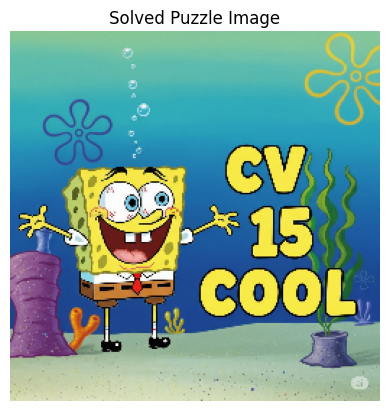

In [168]:
'''
TASK 2 FINAL SOLUTION

This cell replays the steps gathered in interactive mode to reproduce the final solved image.
'''

# Get the image and load it into a transformer class and make a display for it
scrambledImage = cv2.imread("images/geometric_puzzle_scrambled.png")
scrambledImage = cv2.cvtColor(scrambledImage, cv2.COLOR_BGR2RGB)
geometricImageTransformer = ImageTransformer(scrambledImage)
imageDisplayer = ImageDisplay()

# Get logger for replaying steps
geometricLogger = GeometricLogger(logPath="logs/geolog.txt")

# Replay the logged steps to solve the puzzle
geometricLogger.replayLogFile(imageTransformer=geometricImageTransformer)

# Display the solved image
imageDisplayer.showImage(geometricImageTransformer.getImage(), "Solved Puzzle Image")